In [3]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from project.config.db import sync_engine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE

In [4]:
# Select embeddings flattened
repos_df = pd.read_sql("""
SELECT
    r.id,
    r.full_name,
    r.stargazers_count,
    cf.id as fileid,
    e.embedding::text
FROM 
    repositories r
INNER JOIN 
    content_files cf ON r.id = cf.repository_id
INNER JOIN 
    embeddings e ON cf.id = e.file_id
ORDER BY 
    r.stargazers_count DESC;
""", sync_engine)
# repos_df = pd.DataFrame(repos_data)
print(repos_df.head())
print(f'Entries: {repos_df.shape}')
def parse_embedding(embedding_str):
    # Remove brackets and split by comma
    return np.array([float(x) for x in embedding_str.strip('[]').split(',')])
repos_df['embedding'] = repos_df['embedding'].apply(parse_embedding)

         id                               full_name  stargazers_count  fileid  \
0  28457823               freeCodeCamp/freeCodeCamp            401867       1   
1  13491895  EbookFoundation/free-programming-books            334102       2   
2  21737465                    sindresorhus/awesome            325252       3   
3  54346799                 public-apis/public-apis            312722       4   
4  60493101     jwasham/coding-interview-university            304513       5   

                                           embedding  
0  [-7.498295e-05,0.002287827,0.00013612646,-0.01...  
1  [-0.013464205,-0.032628514,-0.010001778,-0.021...  
2  [0.022935227,0.0017856476,-0.021023009,-3.9863...  
3  [-0.02329277,-0.012751098,0.006106108,0.000663...  
4  [0.0115631865,0.0024401157,-0.0034757783,0.016...  
Entries: (95126, 5)


In [5]:
repos_embeddings = repos_df['embedding']
repos_embeddings.index = repos_df['id']
print(repos_embeddings.head())
repos_embeddings[1]

id
28457823    [-7.498295e-05, 0.002287827, 0.00013612646, -0...
13491895    [-0.013464205, -0.032628514, -0.010001778, -0....
21737465    [0.022935227, 0.0017856476, -0.021023009, -3.9...
54346799    [-0.02329277, -0.012751098, 0.006106108, 0.000...
60493101    [0.0115631865, 0.0024401157, -0.0034757783, 0....
Name: embedding, dtype: object


array([ 0.03030053,  0.00287192,  0.01634411, ..., -0.02189796,
        0.00283599,  0.02527106])

In [6]:
X = np.array(repos_df['embedding'].to_list(), dtype=np.float32)
X.shape

(95126, 1024)

In [ ]:
tsne = TSNE(random_state=0, n_iter=1000)
tsne_results = tsne.fit_transform(X)

In [38]:
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['repo_name'] = repos_df['full_name']
df_tsne['repo_read_me'] = repos_df['fileid']

In [39]:
fig, ax = plt.subplots(figsize=(8,6))
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='repo_name', palette='hls')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter Plot of Embeddings Using t-SNE');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')

(np.float64(-94.10685577392579),
 np.float64(93.77329864501954),
 np.float64(-87.49929008483886),
 np.float64(101.81849632263183))

ValueError: Image size of 1776x1990145 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 800x600 with 1 Axes>

In [ ]:
# Check dist of cosine distances
distances = metrics.pairwise.cosine_distances(X)
flat_distances = distances.flatten()
plt.hist(flat_distances, bins=50)
plt.xlabel('Cosine Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Cosine Distances Between Embeddings')
plt.show()

In [100]:
# Apply KMeans
clustering = DBSCAN(eps=0.4, min_samples=2, metric="cosine").fit(X)
labels = clustering.labels_
# kmeans_model = KMeans(n_clusters=17, random_state=1, n_init='auto').fit(X)
# labels = kmeans_model.fit_predict(X)

In [101]:
df_tsne['Cluster'] = labels
df_tsne

,TSNE1,TSNE2,repo_name,repo_read_me,Cluster
0,0.847941,-4.827801,Mini-DALLE3,"<p align=""center"">\n<a href=""https://minidalle...",1
1,-1.036259,-0.053301,python_lcd,lcd_api and i2c_lcd\n===============\n\nPython...,3
2,-1.958258,-1.389272,PyChromeDevTools,# PyChromeDevTools\n\n# 1. Description\nPyChro...,14
3,-3.238291,-3.199424,django-star-ratings,===================\ndjango-star-ratings\n====...,16
4,-1.750679,-1.294279,tcp_udp_web_tools-pyqt5,# tcp_udp_web_tools\r\n配合wangler2333博客创建\r\n博客...,14
...,...,...,...,...,...
95,1.493578,-7.589139,Traffic-Rule-Violation-Detection-System,### Note - I am not able to maintain this repo...,3
96,1.902739,-4.619207,sparkflow,# SparkFlow\n\nThis is an implementation of Te...,0
97,-1.617598,-2.396997,Kyoukai,## Kyōkai (境界)\n\n**This project will not be g...,16
98,-2.270757,-2.001426,GraphCrawler,# GraphCrawler\n\n![](https://github.com/gsmit...,16


(-4.826135206222534, 4.650353002548218, -8.200764960050583, 2.100999540090561)

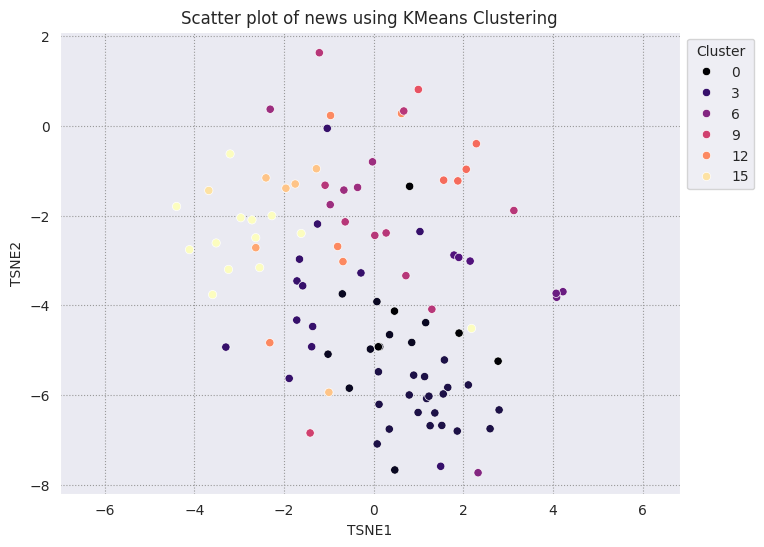

In [102]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Cluster', palette='magma')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using KMeans Clustering');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')

In [125]:
question = "What github repositories should i look into if i want asynchronous Python server-side web framework"
query = genai.embed_content(
    model="models/text-embedding-004",
    content=question)

In [126]:
query_emb = np.array(query['embedding'], dtype=np.float32).reshape(1, -1) # Access the list of floats using the key 'embedding'

In [127]:
from sklearn.metrics.pairwise import cosine_similarity


#Calculate similarity between the user query embedding and cluster centroids
cluster_centroids = kmeans_model.cluster_centers_

#Calculate cosine similarity between the query and the cluster centroids
similarities = cosine_similarity(query_emb, cluster_centroids)

#Find the most similar cluster
most_similar_cluster = np.argmax(similarities)
print(f"Most relevant cluster for the user query: {most_similar_cluster}")

Most relevant cluster for the user query: 16


In [128]:
print(df_tsne.query(f"Cluster == {most_similar_cluster}"))

       TSNE1     TSNE2                 repo_name  \
3  -3.238291 -3.199424       django-star-ratings   
5  -2.630559 -2.490941  Python-developer-roadmap   
21 -2.542979 -3.158942              requirements   
22 -3.512871 -2.609120                 symposion   
24 -2.963811 -2.046551                     scout   
26 -4.107680 -2.758358                    jinjax   
46 -2.714799 -2.094409                 cdr-stats   
70 -3.202570 -0.623614              kestrel-lang   
79 -4.395386 -1.795367                  bacpypes   
89 -3.592787 -3.761505             pandas_flavor   
92  2.180512 -4.514931              sklearnflask   
97 -1.617598 -2.396997                   Kyoukai   
98 -2.270757 -2.001426              GraphCrawler   

                                         repo_read_me  Cluster  
3   ===================\ndjango-star-ratings\n====...       16  
5   # Python Developer Roadmap\n\n> Roadmap to bec...       16  
21  # Requirements\n\n*☛ Python requirements made ...       16  
22  Symposi

In [129]:
df_train["Cluster"] = labels
df_train

,repo_name,readme_content,Embeddings,Cluster
0,Mini-DALLE3,"<p align=""center"">\n<a href=""https://minidalle...","[0.019477655, 0.0017982558, -0.044389483333333...",1
1,python_lcd,lcd_api and i2c_lcd\n===============\n\nPython...,"[0.025261411, -0.008600656156, -0.0816722362, ...",3
2,PyChromeDevTools,# PyChromeDevTools\n\n# 1. Description\nPyChro...,"[0.041799967400000006, -0.017967904200000002, ...",14
3,django-star-ratings,===================\ndjango-star-ratings\n====...,"[-0.00352290632, -0.02522919948, -0.0204847934...",16
4,tcp_udp_web_tools-pyqt5,# tcp_udp_web_tools\r\n配合wangler2333博客创建\r\n博客...,"[0.026030791200000004, 0.00594317192, -0.06646...",14
...,...,...,...,...
95,Traffic-Rule-Violation-Detection-System,### Note - I am not able to maintain this repo...,"[0.0180705831, -0.0024110296666666683, 0.01526...",3
96,sparkflow,# SparkFlow\n\nThis is an implementation of Te...,"[0.006238050740000001, -0.01813388984, -0.0857...",0
97,Kyoukai,## Kyōkai (境界)\n\n**This project will not be g...,"[0.0211756845, -0.0105375718, -0.0002416875000...",16
98,GraphCrawler,# GraphCrawler\n\n![](https://github.com/gsmit...,"[-0.00917253925, -0.004029860999999999, -0.085...",16


In [130]:
#Retrive 2-3 most similar repos

df_wanted = df_train[df_train['Cluster'] == most_similar_cluster]

embeddings_in_cluster = np.array(df_wanted['Embeddings'].to_list(), dtype=np.float32)


similarities = cosine_similarity(query_emb, embeddings_in_cluster)

#get the indices of the top 3 most similar repositories
top_5_similar_repos_indices = np.argsort(similarities[0])[-5:][::-1]  # Sort, get top 5, and reverse to get highest first

#fetch the top 3 repositories based on similarity
top_5_repos = df_wanted.iloc[top_5_similar_repos_indices]


In [131]:
top_5_repos

,repo_name,readme_content,Embeddings,Cluster
5,Python-developer-roadmap,# Python Developer Roadmap\n\n> Roadmap to bec...,"[0.025751219599999996, -0.014141970600000001, ...",16
97,Kyoukai,## Kyōkai (境界)\n\n**This project will not be g...,"[0.0211756845, -0.0105375718, -0.0002416875000...",16
26,jinjax,"<h1>\n <img src=""https://github.com/jpsca/jin...","[-0.01920696, -0.019899651, 0.01750631, -0.035...",16
22,symposion,Symposion\n---------\n\n.. image:: http://slac...,"[0.0251657155, -0.024800099550000003, -0.03821...",16
21,requirements,# Requirements\n\n*☛ Python requirements made ...,"[0.022513443, 0.0008165855000000014, -0.037382...",16


In [132]:
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content(
    f'User: {question}. You are provided with this information : {top_5_repos}. Use ONLY this data to provide me with the information needed . At the end, provide a json formatted file with the most important libraries metioned',
    stream=True
)
for chunk in response:
  print(chunk.text)
  print("_"*80)

Based on the
________________________________________________________________________________
 provided information, here's a breakdown of relevant GitHub repositories for asynchronous Python server-
________________________________________________________________________________
side web frameworks:

**1. Kyoukai (repo_name: 
________________________________________________________________________________
97)**

* **Description:**  The `readme_content` highlights "Kyōkai (境界)" and mentions asynchronous features.  This strongly suggests
________________________________________________________________________________
 it's a framework built for asynchronous operations.
* **Importance:** **HIGH**. It explicitly states asynchronous capabilities, making it a prime candidate for your search.
________________________________________________________________________________


**2. Jinjax (repo_name: 26)**

* **Description:** The `readme_content` focuses on a template engine (`jinjax`) and does